In [1]:
import torch
import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

import utils
from importlib import reload
reload(utils)

/datadrive1/ken/miniconda3/envs/videollama/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'utils' from '/datadrive1/ken/projects/rft-experiments/utils.py'>

In [2]:
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3.5-mini-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")

ds = datasets.load_dataset("openai/gsm8k", "main")

`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.
Loading checkpoint shards: 100%|██████████| 2/2 [01:29<00:00, 44.56s/it]


### Getting basic sense of the data
* Number of steps to solve the problem

Text(0, 0.5, 'Count')

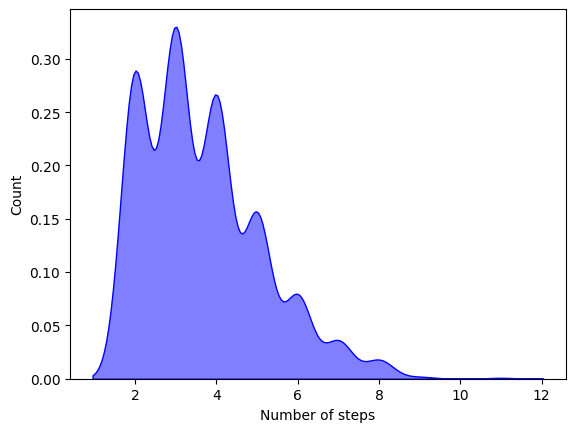

In [3]:
# Count for each answer how many lines it has
# (except the last line, which is the answer)
num_steps = []
for answer in ds["test"]["answer"]:
    lines = answer.split("\n")
    num_steps.append(len(lines) - 1)

fig, ax = plt.subplots()
sns.kdeplot(num_steps, ax=ax, fill=True, color="blue", alpha=0.5)
ax.set_xlabel("Number of steps")
ax.set_ylabel("Count")

### Getting a sense of the baseline, not a perfect replication but good to know where we are at.

In [3]:
prompt_template = """You are given a math question. You must provide a concise step-by-step reasoning
    and a final answer. Your response should follow strictly the format of the provided examples where each new line is a reasoning step
    written in a very concise style, and the final answer is on the last line. There should be roughly 2-4 steps, but it is okay
    to have more or less steps if needed.
    
    {n_shot_examples}

    # Question:
    {question}
"""

In [11]:
# Evaluate the baseline model
print(
    utils.evaluate_model(
        model=model,
        eval_dataset=ds["test"][:4],
        tokenizer=tokenizer,
        prompt_template=prompt_template,
        max_new_tokens=256,
        temperature=0.7,
        batch_size=16,
        num_examples=2,
    )
)

Evaluating model:   0%|          | 0/1 [00:00<?, ?it/s]The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
You are not running the flash-attention implementation, expect numerical differences.
Evaluating model: 100%|██████████| 1/1 [00:11<00:00, 11.27s/it]


0: Decoded answer:
Janet eats 3 eggs for breakfast and uses 4 for muffins, so she uses 3+4=<<3+4=7>>7 eggs daily.
She has 16 eggs in total, so she sells 16-7=<<16-7=9>>9 eggs at the farmers' market.
Since she sells each egg for $2, she makes 9*2=<<9*2=18>>18 dollars every day.
#### 18

1: Decoded answer:
Josh invested $80,000 initially and an additional $50,000 for repairs, totaling $80,000 + $50,000 = $130,000.

The 150% increase in value means the house is now worth 150% more than the initial investment, which is 1.5 * $130,000 = $195,000.

To calculate the profit, subtract the total investment from the increased value: $195,000 - $130,000 = $65,000.

#### 65,000



0.5


### Getting to know more about correct and incorrect sample characteristics
* How often do I get correct vs incorrect? Some questions are harder?
* How sensitive is the above ratio to temperature change?
* For each question, collect perplexity (or self-certainty if thers is time) so we can compare to see if correctness is correlated with these quantities.

In [4]:
def generate_synthetic_data(
        model: AutoModelForCausalLM,
        tokenizer: AutoTokenizer,
        dataset: datasets.Dataset,
        num_samples_per_question: int = 2,
        num_questions: int = 1,
        temperature: float = 0.7,
        max_new_tokens: int = 256,
        num_examples: int = 8,
        batch_size: int = 8,
    ) -> dict:
    """
    Generate synthetic data with full batching across questions and samples.
    """
    questions = dataset['question']
    answers = dataset['answer']

    # Randomly sample `num_examples` examples from the dataset
    # both questions and answers to create n-shot examples
    questions, answers, n_shot_examples = utils.generate_n_shot_examples(
        questions, answers, num_examples=num_examples
    )

    # Pepare all (question_idx, sample_idx) pairs
    all_pairs = []
    for q_idx in range(num_questions):
        for s_idx in range(num_samples_per_question):
            all_pairs.append((q_idx, s_idx))
    
    total_pairs = len(all_pairs)

    # Initialize result containers
    all_solutions = {}
    all_correctness = {}
    all_perplexities = {}
    all_selfcertainties = {}

    for batch_start in tqdm.tqdm(range(0, total_pairs, batch_size), desc="Generating synthetic data"):
        batch_end = min(batch_start + batch_size, total_pairs)
        batch_pairs = all_pairs[batch_start:batch_end]

        # Prepare batch inputs
        batch_chats = []
        batch_question_indices = []
        for q_idx, s_idx in batch_pairs:
            question = questions[q_idx]
            chat = [
                {
                    "role": "user",
                    "content": prompt_template.format(question=question, n_shot_examples=n_shot_examples)
                }
            ]
            batch_chats.append(chat)
            batch_question_indices.append(q_idx)

        # Format all chats
        formatted_chats = [
            tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
            for chat in batch_chats
        ]

        # Tokenize batch
        batch_inputs = tokenizer(
            formatted_chats,
            return_tensors="pt",
            padding=True,
            truncation=True,
        ).to("cuda")
        input_ids = batch_inputs.input_ids
        attention_mask = batch_inputs.attention_mask

        # Generate answers for the batch, also return
        # logits for perplexity and self-certainty computation
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=temperature,
                num_return_sequences=1,  # handled explicitly
                pad_token_id=tokenizer.pad_token_id,
                output_logits=True,
                return_dict_in_generate=True,
            )

        output_ids = outputs.sequences  # shape: (bsz, seq_len)
        logits = outputs.logits         # tuple of (bsz, vocab_size), length = num_new_tokens

        # Convert logits to tensor (bsz, num_new_tokens, vocab_size)
        # in order to compute perplexities and self-certainties
        logits = torch.stack(logits, dim=1)  # shape: (bsz, num_new_tokens, vocab_size)
        gen_ids = output_ids[:, input_ids.shape[1]:]  # only generated tokens, shape: (bsz, num_new_tokens)
        assert gen_ids.shape[1] == logits.shape[1], \
            "Generated tokens and logits must match in length."

        # Compute perplexities and self-certainties
        perplexities, selfcertainties = utils.compute_perplexities_n_selfcertainties(
            logits=logits,
            gen_ids=gen_ids,
            tokenizer=tokenizer,
        )

        # Process results and organize by question
        for i, (q_idx, s_idx) in enumerate(batch_pairs):
            input_length = input_ids.shape[1]
            generated_tokens = output_ids[i, input_length:]
            ans_pred = tokenizer.decode(generated_tokens, skip_special_tokens=True)

            if q_idx not in all_solutions:
                all_solutions[q_idx] = []
                all_correctness[q_idx] = []
                all_perplexities[q_idx] = []
                all_selfcertainties[q_idx] = []
            
            all_solutions[q_idx].append(ans_pred)
            all_correctness[q_idx].append(utils.is_correct_solution(ans_pred, answers[q_idx]))
            all_perplexities[q_idx].append(perplexities[i])
            all_selfcertainties[q_idx].append(selfcertainties[i])
        
        del input_ids, output_ids, attention_mask
        torch.cuda.empty_cache()
    
    return {
        "solutions": all_solutions,
        "correctness_mask": all_correctness,
        "perplexities": all_perplexities,
        "selfcertainties": all_selfcertainties,
        "questions": questions,
        "answers": answers,
        "n_shot_examples": n_shot_examples,
    }

In [7]:
results = generate_synthetic_data(
    model=model,
    tokenizer=tokenizer,
    dataset=ds["train"],
    num_samples_per_question=10,
    num_questions=500,
    temperature=1.5,
    num_examples=2,
    batch_size=32,
)

Generating synthetic data: 100%|██████████| 157/157 [1:00:09<00:00, 22.99s/it]


In [8]:
torch.save(results, "gsm8k_synthetic_data_temp1_5_bsz32_2shot_500questions_train_genOnly_padIgnored.pt")

* How per question correctness ratio looks?

Num. questions: 500


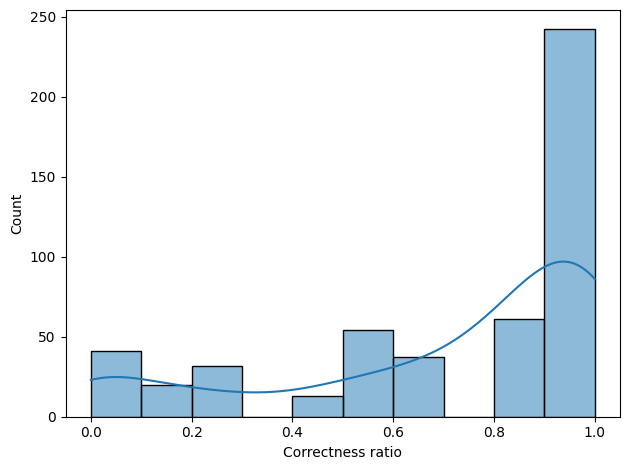

In [12]:
correctness_ratio_x_questions = []
for i, correctness_mask_per_question in results["correctness_mask"].items():
    correctness_ratio_x_questions.append(
        sum(correctness_mask_per_question) / len(correctness_mask_per_question)
    )
print(f"Num. questions: {len(correctness_ratio_x_questions)}")
fig, ax = plt.subplots()
sns.histplot(correctness_ratio_x_questions, ax=ax, bins=10, kde=True)
ax.set_xlabel("Correctness ratio")
ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig("figs/gsm8k_synthetic_data_temp1_5_bsz32_2shot_500questions_train_genOnly_padIgnored_correctness_ratio.png")

* How perplexity and self-certainty correlate with correctness?

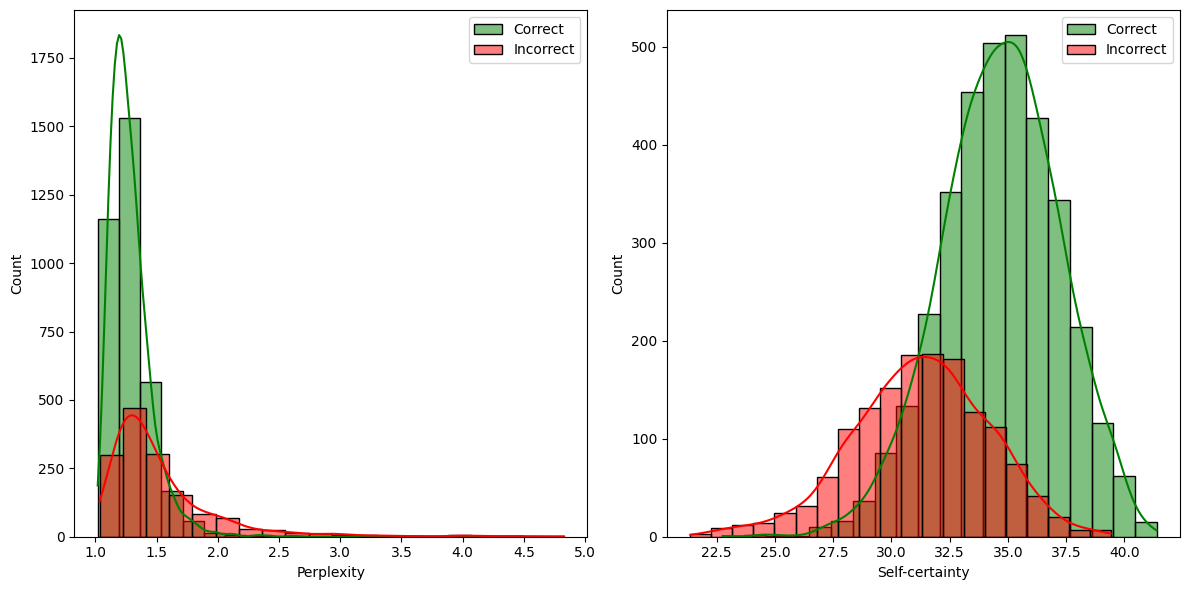

In [11]:
perplexities_correct = []
perplexities_incorrect = []
selfcertainties_correct = []
selfcertainties_incorrect = []
for idx in range(len(results["solutions"])):
    correctness_mask_per_question = torch.tensor(results["correctness_mask"][idx])
    perplexities_per_question = torch.tensor(results["perplexities"][idx])
    selfcertainties_per_question = torch.tensor(results["selfcertainties"][idx])
    perplexities_correct.extend(
        perplexities_per_question[correctness_mask_per_question].tolist()
    )
    perplexities_incorrect.extend(
        perplexities_per_question[~correctness_mask_per_question].tolist()
    )
    selfcertainties_correct.extend(
        selfcertainties_per_question[correctness_mask_per_question].tolist()
    )
    selfcertainties_incorrect.extend(
        selfcertainties_per_question[~correctness_mask_per_question].tolist()
    )

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(perplexities_correct, ax=ax[0], bins=20, kde=True, color="green", label="Correct")
sns.histplot(perplexities_incorrect, ax=ax[0], bins=20, kde=True, color="red", label="Incorrect")
ax[0].set_xlabel("Perplexity")
ax[0].set_ylabel("Count")
ax[0].legend()
sns.histplot(selfcertainties_correct, ax=ax[1], bins=20, kde=True, color="green", label="Correct")
sns.histplot(selfcertainties_incorrect, ax=ax[1], bins=20, kde=True, color="red", label="Incorrect")
ax[1].set_xlabel("Self-certainty")
ax[1].set_ylabel("Count")
ax[1].legend()
plt.tight_layout()
plt.savefig("figs/gsm8k_synthetic_data_temp1_5_bsz32_2shot_500questions_train_genOnly_padIgnored_ppl_n_sc.png")

In [ ]:
# TODO: read into answers and mistakes 
# results["solutions"]

# 